In [28]:
%pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)
# from IPython.display import display

# # 扩展 Notebook 输出区域的高度
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"




  Obtaining dependency information for statsmodels from https://files.pythonhosted.org/packages/67/d8/ac30cf4cf97adaa48548be57e7cf02e894f31b45fd55bf9213358d9781c9/statsmodels-0.14.4-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for scipy!=1.9.2,>=1.8 from https://files.pythonhosted.org/packages/c4/5e/b1b0124be8e76f87115f16b8915003eec4b7060298117715baf13f51942c/scipy-1.15.1-cp312-cp312-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:00
  Obtaining dependency information for patsy>=0.5.6 from https://files.pythonhosted.org/packages/87/2b/b50d3d08ea0fc419c183a84210571eba005328efa62b6b98bc28e9ead32a/patsy-1.0.1-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 5.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 2.9 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 8.1 MB/s eta 0:00:0000:0100:01

In [13]:
weather = pd.read_parquet('./public/meteo.parquet')
weather['date'] = pd.to_datetime(weather['date'], utc=True)
print(weather.tail())

       numer_sta                      date      pmer   tend cod_tend     dd   ff       t      td     u       vv  ww    w1    w2      n nbas  hbas    cl    cm    ch      pres  niv_bar  geop  tend24    tn12  tn24    tx12  tx24  tminsol    sw  tw  raf10  rafper   per etat_sol  ht_neige  ssfrai  perssfrai  rr1  rr3  rr6  rr12  rr24  phenspe1  phenspe2  phenspe3 phenspe4  nnuage1 ctype1  hnuage1  nnuage2 ctype2  hnuage2  nnuage3 ctype3  hnuage3 nnuage4 ctype4  hnuage4                                                                  coordonnees                nom                                                                               type_de_tendance_barometrique                                                                         temps_passe_1                                                                      temps_present   tc  tn12c  tn24c  tx12c  tx24c  tminsolc   latitude  longitude  altitude                  libgeo codegeo  \
695155     07335 2022-12-17 15:00:00+00:00  10217

In [14]:
# 示例：统计巴黎的天气数据时间分布
paris_weather = weather[weather['nom_epci'] == 'Métropole du Grand Paris']
print(paris_weather['date'].dt.hour.value_counts().sort_index())

date
0     2184
3     2186
6     2184
9     2189
12    2189
15    2191
18    2187
21    2190
Name: count, dtype: int64


<Axes: xlabel='hour', ylabel='nom_epci'>

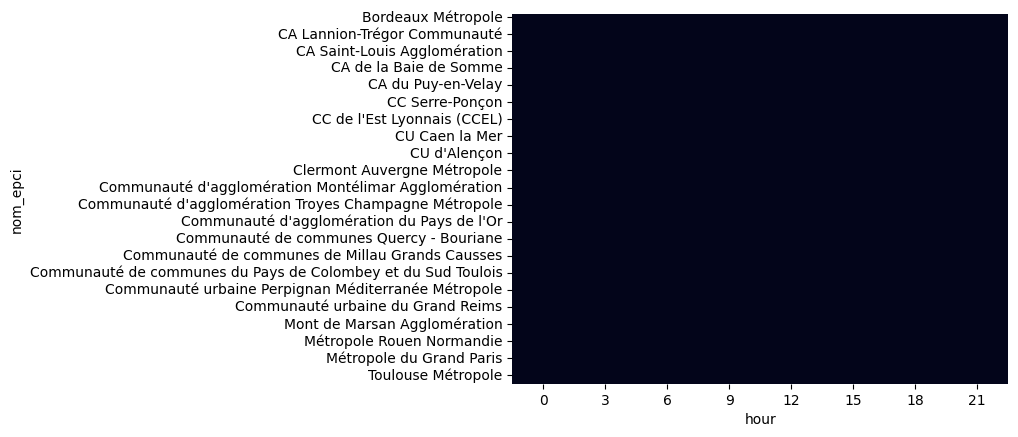

In [10]:
weather['hour'] = weather['date'].dt.hour
missing_heatmap = weather.pivot_table(
    index='nom_epci', columns='hour', values='t', aggfunc='count', fill_value=0
)
sns.heatmap(missing_heatmap == 0, cbar=False)  # 白色表示缺失

统计每个城市的数据数量，看看有没有哪些是极端缺失的情况

In [21]:
city_counts = weather['libgeo'].value_counts()
display(city_counts)

libgeo
Mérignac                     17508
Blagnac                      17505
Saint-Aignan-Grandlieu       17505
Bourges                      17504
Marignane                    17503
Barberey-Saint-Sulpice       17501
Fretin                       17501
Nice                         17500
Athis-Mons                   17500
Colombier-Saugnieu           17496
Perpignan                    17495
Blotzheim                    17495
Limoges                      17493
Parçay-Meslay                17492
Poitiers                     17485
Holtzheim                    17482
Saint-Jacques-de-la-Lande    17482
Prunay                       17478
Boos                         17470
Louey                        17458
Embrun                       17456
Ouges                        17446
Montélimar                   17444
Thuilley-aux-Groseilles      17439
Carpiquet                    17438
Guipavas                     17437
Gourdon                      17433
Mont-de-Marsan               17432
Bangor       

我们可以看到每个城市都差不多是17000多条数据，缺失值还是相对较少仅仅最后的 SD Oleron 缺失的比较多，后续可以查看它的分布，如果过于难处理，或者它所处的区域已经被别的城市覆盖，可以酌情不使用它

In [23]:
bourges_weather = weather[weather['libgeo'] == 'Bourges']
print(bourges_weather['date'].sort_values())


161887   2017-01-01 00:00:00+00:00
41811    2017-01-01 03:00:00+00:00
41812    2017-01-01 06:00:00+00:00
99729    2017-01-01 09:00:00+00:00
55642    2017-01-01 12:00:00+00:00
144393   2017-01-01 15:00:00+00:00
99732    2017-01-01 18:00:00+00:00
138120   2017-01-01 21:00:00+00:00
18479    2017-01-02 00:00:00+00:00
138126   2017-01-02 03:00:00+00:00
46539    2017-01-02 06:00:00+00:00
7393     2017-01-02 09:00:00+00:00
76378    2017-01-02 12:00:00+00:00
48744    2017-01-02 15:00:00+00:00
96019    2017-01-02 18:00:00+00:00
29783    2017-01-02 21:00:00+00:00
71291    2017-01-03 00:00:00+00:00
7402     2017-01-03 03:00:00+00:00
120651   2017-01-03 06:00:00+00:00
129723   2017-01-03 09:00:00+00:00
120655   2017-01-03 12:00:00+00:00
77466    2017-01-03 15:00:00+00:00
82010    2017-01-03 18:00:00+00:00
18534    2017-01-03 21:00:00+00:00
127058   2017-01-04 00:00:00+00:00
138421   2017-01-04 03:00:00+00:00
29802    2017-01-04 06:00:00+00:00
151009   2017-01-04 09:00:00+00:00
28484    2017-01-04 

In [26]:
# 筛选出 libgeo 为 Bourges 的数据
bourges_data = weather[weather['libgeo'] == 'Saint-Denis-d\'Oléron']

# 统计每个时间点的缺失值数量
missing_values_by_time = bourges_data.isnull().sum()

# 打印结果
print(missing_values_by_time)

numer_sta                            0
date                                 0
pmer                                74
tend                                 2
cod_tend                             2
dd                                  13
ff                                  13
t                                   18
td                                  74
u                                   61
vv                                6035
ww                                5210
w1                                1892
w2                               13847
n                                 5228
nbas                              5265
hbas                              7315
cl                                5317
cm                                8116
ch                               10106
pres                                 1
niv_bar                          15697
geop                             15697
tend24                             169
tn12                             11749
tn24                     

我试了 Bourges，发现时间缺失是 0，换了个上面两个那里显示最少的城市，结果还是时间缺失 0，那肯定是代码的问题了，可能这里代码的逻辑是找出所有名字是 xxx 的城市，然后发现只要名字出现，就有对应的时间列，所以时间从来对城市名来说不是空值。
但我想知道的是，对比整体的时间，从 2017年开始到 2022年底结束，中间每个城市都缺了多少？

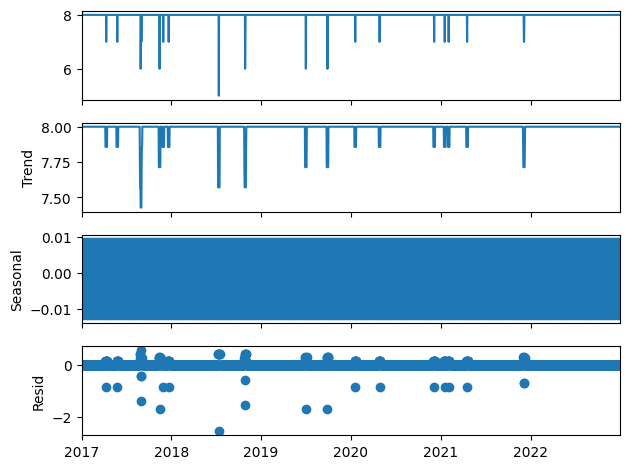

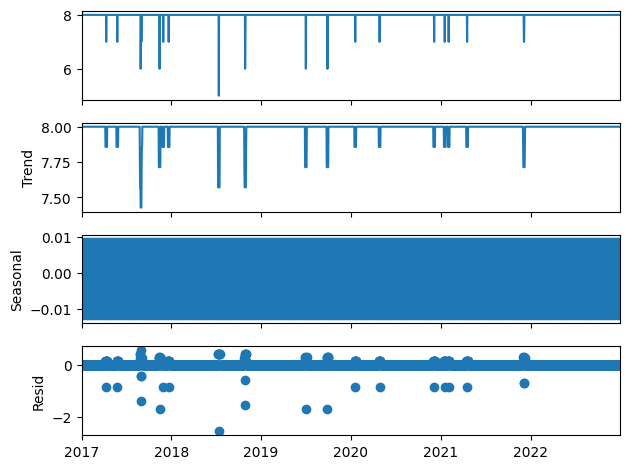

In [29]:
# 按天聚合数据量，观察周期性
daily_counts = paris_weather.resample('D', on='date').size()
decomposition = seasonal_decompose(daily_counts, period=7)  # 周周期假设
decomposition.plot()

我尝试按城市来展示温度 t 的缺失情况，发现 Saint-Mandrier-sur-Mer 缺少了近 50% 的温度数据，这个连补充缺失值都不太好做了，所以后续应该把这个城市删掉。

In [32]:
missing_stats = weather.groupby('libgeo')['t'].apply(
    lambda x: x.isnull().mean()
).sort_values(ascending=False)
print(missing_stats)

libgeo
Saint-Mandrier-sur-Mer       0.485752
La Hague                     0.036121
Perpignan                    0.005201
Perros-Guirec                0.002785
Montélimar                   0.002408
Saint-Denis-d'Oléron         0.001147
Guipavas                     0.001090
Prunay                       0.001087
Mont-de-Marsan               0.001033
Blagnac                      0.000914
Marignane                    0.000514
Clermont-Ferrand             0.000406
Blotzheim                    0.000400
Nice                         0.000400
Poitiers                     0.000343
Carpiquet                    0.000229
Holtzheim                    0.000229
Mauguio                      0.000175
Bangor                       0.000172
Thuilley-aux-Groseilles      0.000172
Boos                         0.000172
Saint-Aignan-Grandlieu       0.000171
Millau                       0.000115
Saint-Jacques-de-la-Lande    0.000114
Colombier-Saugnieu           0.000114
Chaspuzac                    0.000059
Lorp-

在温度之后，我们还可以依次对其他风速、湿度等等常见的数据进行同样的缺失值计算，还可以详细研究天气数据表中到底有哪些元素，哪些是对用电量有明显影响的？